# Develop a Reinforcement Learning RNN with sampling one-hot

author: [zzj](http://zj-zhang.github.io);	date: Jan. 20, 2019;	last update: Jan. 20, 2019

----

In this notebook we will develop a recurrent neural network (actually two, a sampling RNN and a training RNN) that 
first samples a set of one-hot actions given the current state $\pi_{\theta}(a_t|s_t)$, then learns from the feedback of the environment to maximize a target function, i.e. a clipped form of 
$$r_t=\frac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}\cdot A_t$$

where the advantage/reward $A_t$ is determined from the environment.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-State_space-from-BioNAS" data-toc-modified-id="Import-State_space-from-BioNAS-1">Import State_space from BioNAS</a></span></li><li><span><a href="#Define-Inputs-and-other-params-for-RNN" data-toc-modified-id="Define-Inputs-and-other-params-for-RNN-2">Define Inputs and other params for RNN</a></span></li><li><span><a href="#Define-sample-RNN-and-train-RNN" data-toc-modified-id="Define-sample-RNN-and-train-RNN-3">Define sample RNN and train RNN</a></span></li><li><span><a href="#Synchronize-weights-between-sample_RNN-and-train_RNN" data-toc-modified-id="Synchronize-weights-between-sample_RNN-and-train_RNN-4">Synchronize weights between sample_RNN and train_RNN</a></span></li><li><span><a href="#Define-the-Loss-function-for-proximal-policy-optimization" data-toc-modified-id="Define-the-Loss-function-for-proximal-policy-optimization-5">Define the Loss function for proximal-policy optimization</a></span></li><li><span><a href="#Define-KL-divergence-function-for-early-stopping" data-toc-modified-id="Define-KL-divergence-function-for-early-stopping-6">Define KL-divergence function for early stopping</a></span></li><li><span><a href="#Wrapping-up:-A-Working-Example" data-toc-modified-id="Wrapping-up:-A-Working-Example-7">Wrapping up: A Working Example</a></span></li></ul></div>

### Import State_space from BioNAS
We will use an existing state_space in BioNAS.

In [1]:
%matplotlib inline
from BioNAS.Controller.state_space import *

def get_state_space():
    '''State_space is the place we define all possible operations (called `States`) on each layer to stack a neural net. 
    The state_space is defined in a layer-by-layer manner, i.e. first define the first layer (layer 0), then layer 1, 
    so on and so forth. See below for how to define all possible choices for a given layer.
    Note:
        Use key-word arguments to define layer-specific attributes. 
        Adding `Identity` state to a layer is basically omitting a layer by performing no operations.
    Args:
        None
    Returns:
        a pre-defined state_space object
    '''
    state_space = StateSpace()
    state_space.add_layer(0, [
        State('conv1d', filters=3, kernel_size=10, kernel_initializer='glorot_uniform', activation='relu', name="conv1"), 
        State('conv1d', filters=3, kernel_size=6, kernel_initializer='glorot_uniform', activation='relu', name="conv1"), 
        State('conv1d', filters=10, kernel_size=10, kernel_initializer='glorot_uniform', activation='relu', name="conv1"),
        State('conv1d', filters=10, kernel_size=6, kernel_initializer='glorot_uniform', activation='relu', name="conv1"),
        State('conv1d', filters=3, kernel_size=10, kernel_initializer='glorot_normal', activation='relu', name="conv1"),
        State('conv1d', filters=3, kernel_size=6, kernel_initializer='glorot_normal', activation='relu', name="conv1"),
        State('conv1d', filters=10, kernel_size=10, kernel_initializer='glorot_normal', activation='relu', name="conv1"),
        State('conv1d', filters=10, kernel_size=6, kernel_initializer='glorot_normal', activation='relu', name="conv1"),
    ])
    state_space.add_layer(1, [
        State('Identity'),
        State('maxpool1d', pool_size=10, strides=10), 
        State('avgpool1d', pool_size=10, strides=10),
    ])
    state_space.add_layer(2, [
        State('Flatten'), 
        State('GlobalMaxPool1D'), 
        State('GlobalAvgPool1D')
    ])
    state_space.add_layer(3, [
        State('Dense', units=3, activation='relu'), 
        State('Dense', units=10, activation='relu'), 
        State('Identity') 
    ])    
    return state_space

state_space = get_state_space()
print(state_space)

StateSpace with 4 layers and 216 total combinations


### Define Inputs and other params for RNN
We will define the input tensors along with a few other nuance parameters first.
- maxlen: length of the state-space; here is 4;
- input_dim: the input dimension for RNN cell after each one-hot actin embedding;
- controller_units: number of units in RNN cell, controlls complexity of the model;
- last_output_dim: dimension for the last state in state_space, determines the current state;

Input tensors:
- state_inputs: tensor for states (input for the `sample_RNN` and `train_RNN`), shape consistent with last_output_dim
- action_inputs: tensor for one-hot actions (input for `train_RNN`).

In BioNAS this will go to the `__init__` for a new `Controller` instance.

In [2]:
import keras.backend as K
import numpy as np
import random
from keras.models import Model
from keras.layers import Input, Lambda, Dense
from keras import optimizers
from keras.losses import mean_squared_error, binary_crossentropy, categorical_crossentropy
from keras.metrics import kullback_leibler_divergence

maxlen = len(state_space)
input_dim = 8
controller_units = 16
last_output_dim = len(state_space.state_space[maxlen - 1])

state_inputs = Input((1, last_output_dim), batch_shape=(None, 1, last_output_dim), name='sample_actor/state')  # states
action_inputs = [Input((1, last_output_dim), batch_shape=(None, 1, last_output_dim), name='train_actor/state')]
for t in range(maxlen):
    this_size = len(state_space.state_space[t])
    action_inputs.append( Input( (1,this_size), batch_shape=(None, 1, this_size), name='train_actor/input_%i'%t) )


/home/user/Programs/Anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Define sample RNN and train RNN
Given the input tensors defined previously, we will have two global models: `sample_model` and `train_model`. 

In [3]:
import keras.backend as K
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Lambda, Flatten, Activation
from keras.initializers import uniform
import tensorflow as tf


def build_sample_actor(inputs, rnn_units, input_dim, maxlen, state_space, scope, trainable=True):
    
    rnn = LSTM(rnn_units, return_state=True, stateful=False, name=scope+'/NAScell', trainable=trainable)

    outputs = [] # pi
    action = []
    embeds = []

    state = None
    expand_layer = Lambda(expand, output_shape=lambda s: (s[0], 1, s[1]), name=scope+'/expand_layer')

    for t in range(maxlen):
        if t == 0:
            input_t = inputs
            input_t = Dense(input_dim, activation='linear', use_bias=False, name=scope+'/embed_input', trainable=trainable)(input_t)
        else:
            input_t = embeds[-1]
            input_t = expand_layer(input_t)
        num_choices = len(state_space[t])
        output_t, h, c = rnn(input_t, initial_state=state)#K.shape(inputs[0])[0])
        state = h, c
        logits = Dense(num_choices, name=scope+'/logits_%i' % t, trainable=trainable)(output_t)
        output_t_prob = Activation('softmax', name=scope+'/sofmax_%i'%t)(logits)
        a = Lambda(lambda L: K.squeeze(tf.multinomial(L,1), axis=1), name=scope+'/multinomial_%i'%t)(logits)
        a = Lambda(lambda L: K.one_hot(K.cast(L,'int32'), num_classes=num_choices), name=scope+'/onehot_%i'%t)(a)
        
        action.append(a)
        embed_t = Dense(input_dim, activation='linear', name=scope+'/embed_%i' % t, trainable=trainable)(a)
        outputs.append(output_t_prob)
        embeds.append(embed_t)

    return outputs, action


def build_train_actor(inputs, rnn_units, input_dim, maxlen, state_space, scope, trainable=True):

    rnn = LSTM(rnn_units, return_state=True, stateful=False, name=scope+'/NAScell', trainable=trainable)

    outputs = [] # pi
    embeds = []

    state = None
    expand_layer = Lambda(expand, output_shape=lambda s: (s[0], 1, s[1]), name=scope+'/expand_layer')

    for t in range(maxlen):
        if t == 0:
            input_t = inputs[0]
            input_t = Dense(input_dim, activation='linear', use_bias=False, name=scope+'/embed_input', trainable=trainable)(input_t)
        else:
            input_t = embeds[-1]
        num_choices = len(state_space[t])
        output_t, h, c = rnn(input_t, initial_state=state)#K.shape(inputs[0])[0])
        state = h, c
        logits = Dense(num_choices, name=scope+'/logits_%i' % t, trainable=trainable)(output_t)
        output_t_prob = Activation('softmax', name=scope+'/sofmax_%i'%t)(logits)
        
        embed_t = Dense(input_dim, activation='linear', name=scope+'/embed_%i' % t, trainable=trainable)(inputs[t+1])
        outputs.append(output_t_prob)
        embeds.append(embed_t)

    return outputs

def expand(x):
    return K.expand_dims(x, 1)

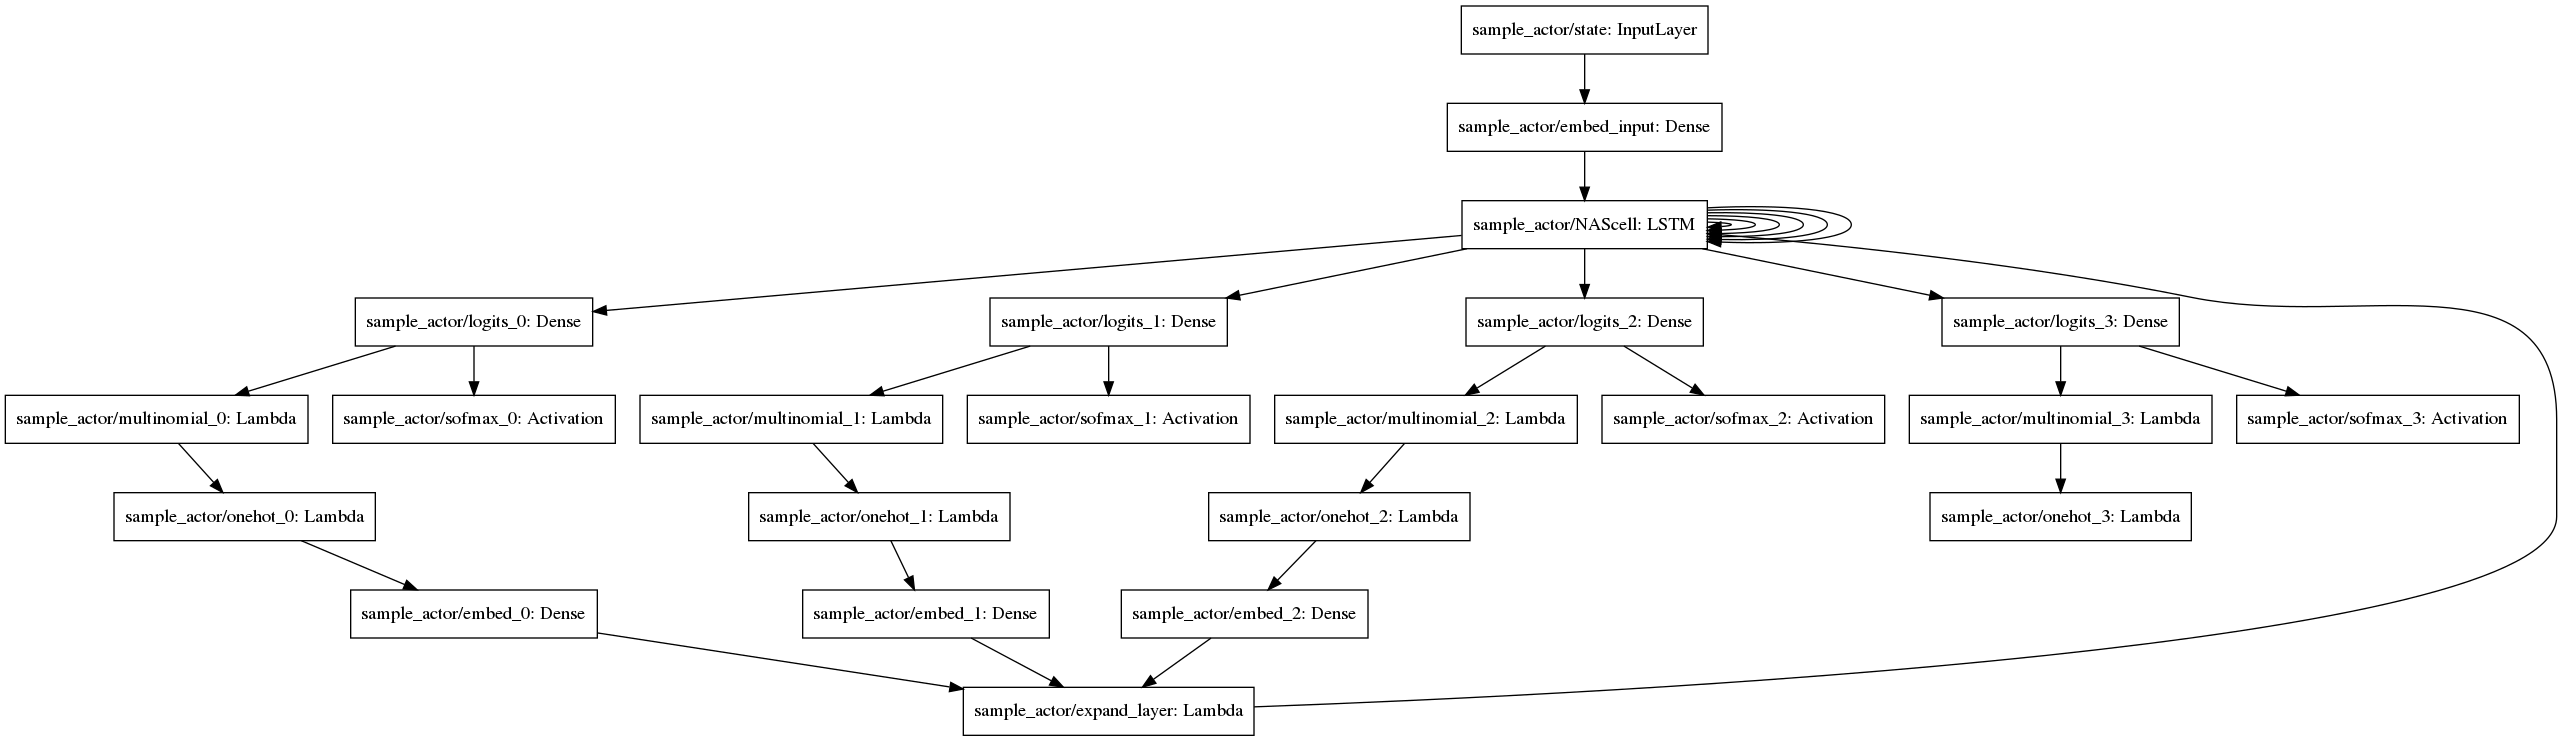

In [4]:
sample_outputs, sample_action = build_sample_actor(state_inputs, controller_units, input_dim, maxlen, state_space,
                              scope='sample_actor', trainable=True)

train_outputs = build_train_actor(action_inputs, controller_units, input_dim, maxlen, state_space,
                              scope='train_actor', trainable=True)

# build model with Keras Model API
sample_model = Model(inputs=state_inputs, outputs=sample_outputs+sample_action)
train_model = Model(inputs=action_inputs, outputs=train_outputs)

from IPython.display import Image
from keras.utils import plot_model
#sample_model.summary()
plot_model(sample_model, to_file="img/sample_RNN.png")
Image('img/sample_RNN.png')

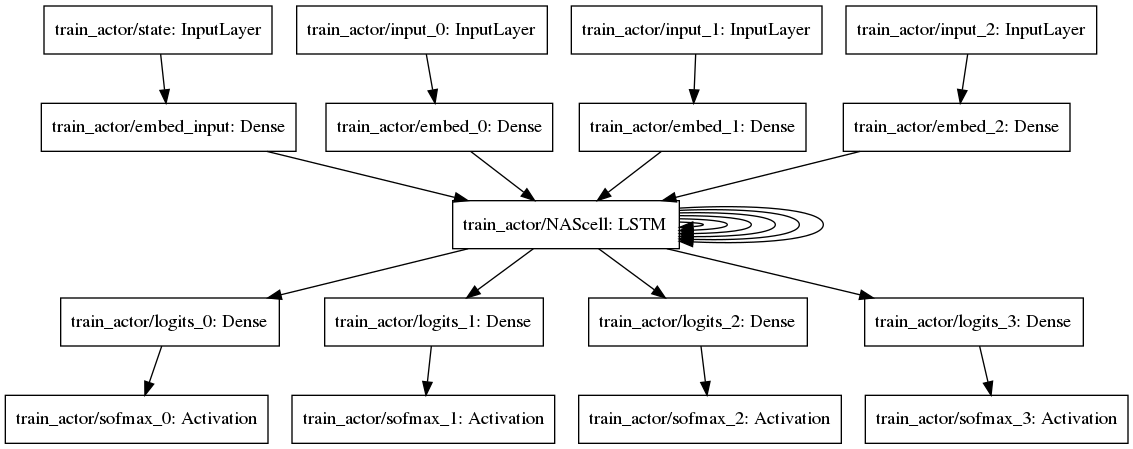

In [5]:
from IPython.display import Image
from keras.utils import plot_model
#train_model.summary()
plot_model(train_model, to_file="img/train_RNN.png")
Image('img/train_RNN.png')

### Synchronize weights between sample_RNN and train_RNN
We will use `set_weights` and `get_weights`. 

NOTE: a better way is probably for these two RNNs to share weights.

In [6]:
def sync_weights(train_model, sample_model):
    train_model_layer_dict = {x.name:x for x in train_model.layers}
    sample_model_layer_dict = {x.name:x for x in sample_model.layers}
    for train_layer in train_model_layer_dict:
        if not train_model_layer_dict[train_layer].trainable:
            continue
        sample_layer = 'sample_actor/' + train_layer.split('/')[1]
        sample_model_layer_dict[sample_layer].set_weights(train_model_layer_dict[train_layer].get_weights())

In [7]:
sync_weights(train_model, sample_model)

### Define the Loss function for proximal-policy optimization
The end product is the training function `atrain_fn` that minimizes the proximal-policy loss `aloss`.

In [8]:
def proximal_policy_optimization_loss(train_model, old_probs, rewards, advantage, clip_val):

    #rewards = K.squeeze(rewards, axis=1)  # check the buffer for dimensionality
    #advantage = K.squeeze(advantage, axis=1)
    r = 1  # the ratio function
    old_onehots_expand = train_model.inputs
    old_onehots = [K.squeeze(x, 1) for x in old_onehots_expand[1:]]
    curr_probs = train_model.outputs

    for t, (p, old_p, old_onehot) in enumerate(zip(curr_probs, old_probs, old_onehots)):
        r = r * K.exp(K.log(K.sum(old_onehot * p, axis=1)) - K.log(K.sum(old_onehot * old_p, axis=1))) ## prob / old_prob w.r.t old action taken

    surr_obj = K.mean( K.abs(1/(rewards+1e-8)) * K.minimum(r * advantage, ## some trick for scaling gradients by reward... K.abs(1/(rewards+1e-8))
                             K.clip(r, min_value=1 - clip_val, max_value=1 + clip_val) * advantage))

    return - surr_obj ## maximize surr_obj for learning

In [9]:
old_prob_placeholder = [K.placeholder(shape=K.int_shape(sample_outputs[t]),
                                    name="old_pred_%i" % t) for t in range(maxlen)]
reward_placeholder = K.placeholder(shape=(None, 1),
                                name="normal_reward")
advantage_placeholder = K.placeholder((None,1), name='advantage')  # advantages

aloss = proximal_policy_optimization_loss(train_model, old_prob_placeholder, 
                                          reward_placeholder, advantage_placeholder, 0.2)

a_optimizer = optimizers.Adam(lr=0.01, decay=0.999)
aupdates = a_optimizer.get_updates(params=[w for w in train_model.trainable_weights if w.name.startswith('train_actor')],
                           loss=aloss)
## action_input +
## old prob_sample at time t +
## reward and advatange array
atrain_inputs = train_model.inputs + \
                old_prob_placeholder + \
                [reward_placeholder, advantage_placeholder]   
atrain_fn = K.function(inputs=atrain_inputs,
                                   outputs=[aloss],
                                   updates=aupdates)

### Define KL-divergence function for early stopping

We can also add the kl-divergence between the new probs. from train_model and the old probs, for any given onehot actions. This is for early-stopping purpose, aside from the clipping of the ratio function

In [10]:
def get_kl_divergence(train_model, old_probs):
    """
    compute approx kl and entropy
    return kl, ent

    """
    new_prob = train_model.outputs
    kl = [ kullback_leibler_divergence(old_p, new_p)  for old_p, new_p in zip(old_probs, new_prob) ]
    #ent = [ binary_crossentropy(new_oh, new_p)  for new_p, new_oh in zip(new_prob, new_onehot) ]
    return K.mean(sum(kl))

In [11]:
kl_div = get_kl_divergence(train_model, old_prob_placeholder)
kl_div_fn = K.function(inputs=train_model.inputs+old_prob_placeholder, outputs=[kl_div])

### Wrapping up: A Working Example
We will test the predict and train functions for `sample_model` and `train_model`. First synchronize the weights.

In [12]:
sync_weights(train_model, sample_model)

state_inputs_arr = np.array([1,0,0,0,1,0]).reshape((2,1,3))
s = sample_model.predict(state_inputs_arr)
prob_sample, action_sample = s[:4], s[4:]
action_input = [np.expand_dims(x,1) for x in action_sample] ## need to expand dimension for `train_model`
prob_train = train_model.predict([state_inputs_arr]+action_input)

print(prob_sample) ## these two probs should be identical
print(prob_train)

[array([[0.11651286, 0.11973583, 0.14057541, 0.12708083, 0.12278837,
        0.12450201, 0.11724677, 0.13155794],
       [0.12377858, 0.1339965 , 0.1166409 , 0.13544242, 0.13352165,
        0.12562235, 0.12014628, 0.1108513 ]], dtype=float32), array([[0.3652267 , 0.3161796 , 0.31859374],
       [0.32551   , 0.34180436, 0.33268565]], dtype=float32), array([[0.36293077, 0.263681  , 0.37338823],
       [0.31585148, 0.39366293, 0.29048562]], dtype=float32), array([[0.3221936 , 0.35233662, 0.3254698 ],
       [0.3498104 , 0.29932702, 0.35086262]], dtype=float32)]
[array([[0.11651286, 0.11973583, 0.14057541, 0.12708083, 0.12278837,
        0.12450201, 0.11724677, 0.13155794],
       [0.12377858, 0.1339965 , 0.1166409 , 0.13544242, 0.13352165,
        0.12562235, 0.12014628, 0.1108513 ]], dtype=float32), array([[0.3652267 , 0.3161796 , 0.31859374],
       [0.32551   , 0.34180436, 0.33268565]], dtype=float32), array([[0.36293077, 0.263681  , 0.37338823],
       [0.31585148, 0.39366293, 0.29048

In [13]:
reward_arr = np.array([[1, 1]])
advantage_arr = np.array([[1, -1]])  ## we deliberately make the first action with positive advantage,
                                     ## and the second one with negative advantage
train_inputs = [state_inputs_arr] + action_input + prob_sample + [ reward_arr, advantage_arr ] 
len(train_inputs)

11

In [14]:
aloss_list = []
kl_list = []
for _ in range(30):
    aloss_list.append(atrain_fn(train_inputs)[0])
    kl_list.append(kl_div_fn(train_inputs[:-2])[0])

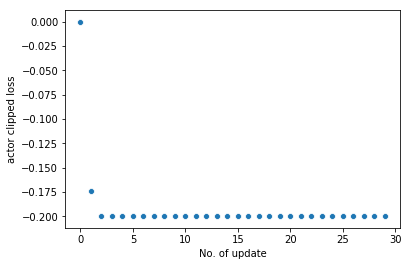

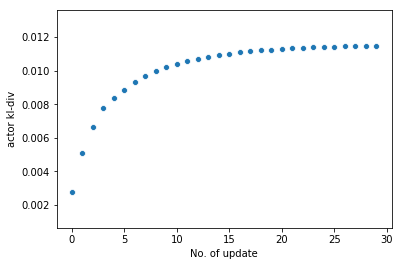

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.clf()
ax1 = sns.scatterplot(x=np.arange(len(aloss_list)), y=aloss_list)
ax1.set_xlabel('No. of update')
ax1.set_ylabel('actor clipped loss')
plt.show()

plt.clf()
ax2 = sns.scatterplot(x=np.arange(len(aloss_list)), y=kl_list)
ax2.set_xlabel('No. of update')
ax2.set_ylabel('actor kl-div')
plt.show()


In [16]:
prob_train = train_model.predict([state_inputs_arr]+action_input)
print("sample1 one-hot action's prob before train: ", [sum(action_input[t][0].flatten()*prob_sample[t][0]) for t in range(maxlen)] )
print("sample1 one-hot action's prob after train: ", [sum(action_input[t][0].flatten()*prob_train[t][0]) for t in range(maxlen)])


sample1 one-hot action's prob before train:  [0.13155794143676758, 0.31859374046325684, 0.37338823080062866, 0.3523366153240204]
sample1 one-hot action's prob after train:  [0.14099626243114471, 0.3372698128223419, 0.4172324240207672, 0.394959419965744]


In [17]:
print("sample2 one-hot action's prob before train: ", [sum(action_input[t][1].flatten()*prob_sample[t][1]) for t in range(maxlen)] )
print("sample2 one-hot action's prob after train: ", [sum(action_input[t][1].flatten()*prob_train[t][1]) for t in range(maxlen)])

sample2 one-hot action's prob before train:  [0.1335216462612152, 0.3418043553829193, 0.31585147976875305, 0.29932701587677]
sample2 one-hot action's prob after train:  [0.1232018768787384, 0.309551477432251, 0.2752220332622528, 0.25894248485565186]
